In [164]:
import kinetics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'
print(kinetics.__version__)

import itertools
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

1.4.3


Loading BokehJS ...

## Perfect enzyme modal
In this model I've set all the enzyme parameters to very good (but plausible) values.  The kcats are particually high.  

I've done this to try to get a feel for how the thermodynamics are limiting the reaction.  

In [222]:
ired = kinetics.Tri_Tri_seq_eq(kcat='ired_kcat',
                              kma='ired_km_nadph', kmb='ired_km_aldehyde', kmc='ired_km_nh2',
                              kmp='ired_km_nadp', kmq='ired_km_amine', kmr='ired_km_h2o',
                              keq='ired_keq',
                              a='nadph', b='aldehyde', c='nh2', p='nadp', q='amine', r='h2o', enz='ired',
                              substrates=['nadph', 'aldehyde', 'nh2'], products=['nadp', 'amine'])

ired.parameters = {'ired_km_nadph': 100,
                   'ired_km_aldehyde': 500,
                   'ired_km_nh2': 500,
                   'ired_km_nadp': 100,
                   'ired_km_amine': 500,
                   'ired_km_h2o': 500,
                   'ired_kcat': 1000}

ired.parameter_distributions = {'ired_keq': (642000,20600000)}

adh = kinetics.Bi_Bi_sep_eq(kcat='adh_kcat',
                            kma='adh_km_nadp', kmb='adh_km_alcohol',
                            kmp='adh_km_nadph', kmq='adh_km_aldehyde',
                            keq='adh_keq',
                            a='nadp', b='alcohol', p='nadph', q='aldehyde', enz='adh',
                            substrates=['nadp', 'alcohol'], products=['nadph', 'aldehyde'])

adh.parameters = {'adh_km_nadph': 100,
                  'adh_km_alcohol': 500,
                  'adh_km_nadp': 100,
                  'adh_km_aldehyde': 500,
                  'adh_kcat': 1000}

adh.parameter_distributions = {'adh_keq': (0.00106, 0.00289)}

In [223]:
# Set up the model
model = kinetics.Model()

# Add reactions
model.append(ired)
model.append(adh)

In [224]:
# calc conc (uM) of enzyme for 10 mg/ml
mgml = kinetics.mgml_to_uM({'ired': 31500, 'adh': 35200}, 
                           {'ired': 10, 'adh': 10})
print(mgml)

{'ired': 317.46, 'adh': 284.09}


In [225]:
# Set time
model.set_time(0, 60*24, 500)

# Set starting concentrations with no error
# Issue setting concs to 0, so initialise at 1.
model.species = {"ired" : 320,
                 "adh": 285,
                 "nadph": 250,
                 "nadp": 250,
                 "alcohol": 9998,
                 "aldehyde": 1,
                 "amine": 1,
                 "nh2": 50000,  # 5 equivs.
                 'h2o': 5500000}

# Command to prepare model for running.
model.setup_model()

In [226]:
# Run the model 1000 times, sampling from distributions
samples = kinetics.sample_uniforms(model, num_samples=200)
outputs = kinetics.run_all_models(model, samples)
df95 = kinetics.dataframes_quartiles(model, outputs, quartile=95)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.63it/s]


-- Alcohol --


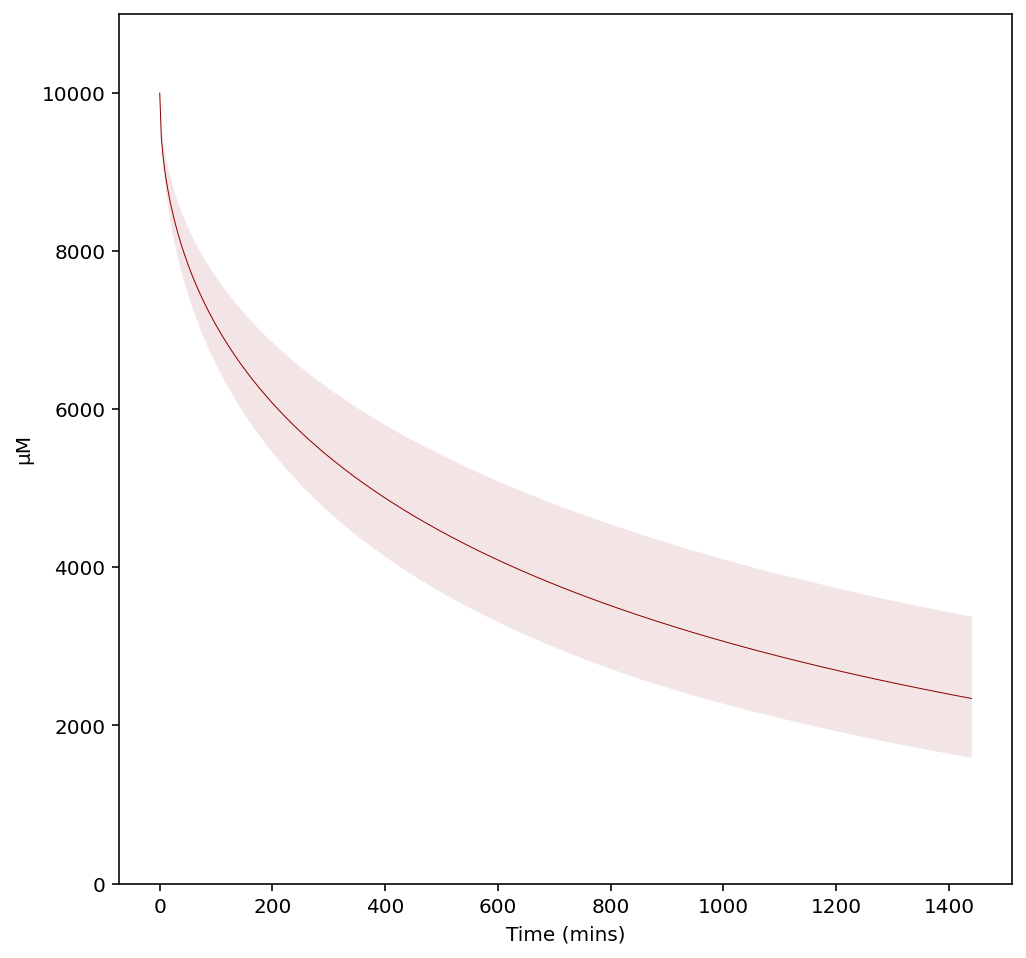

-- Aldehyde --


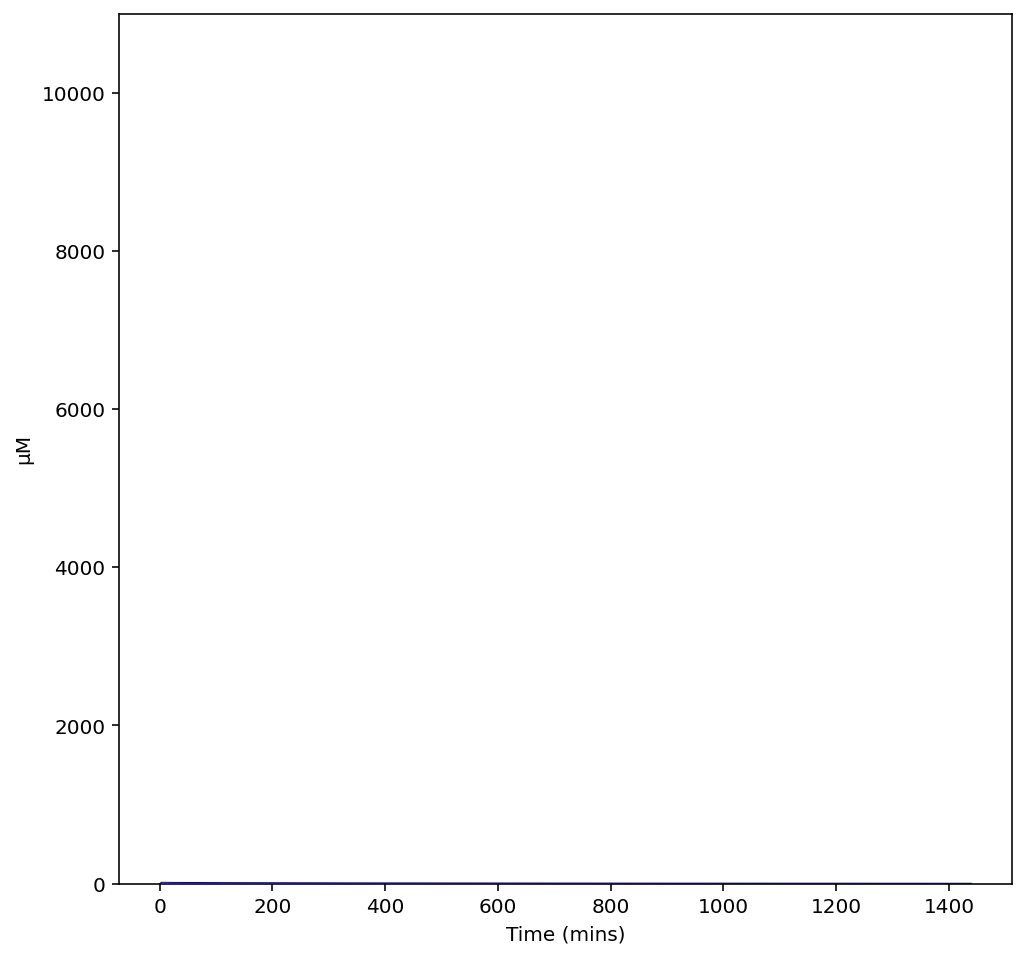

-- Amine --


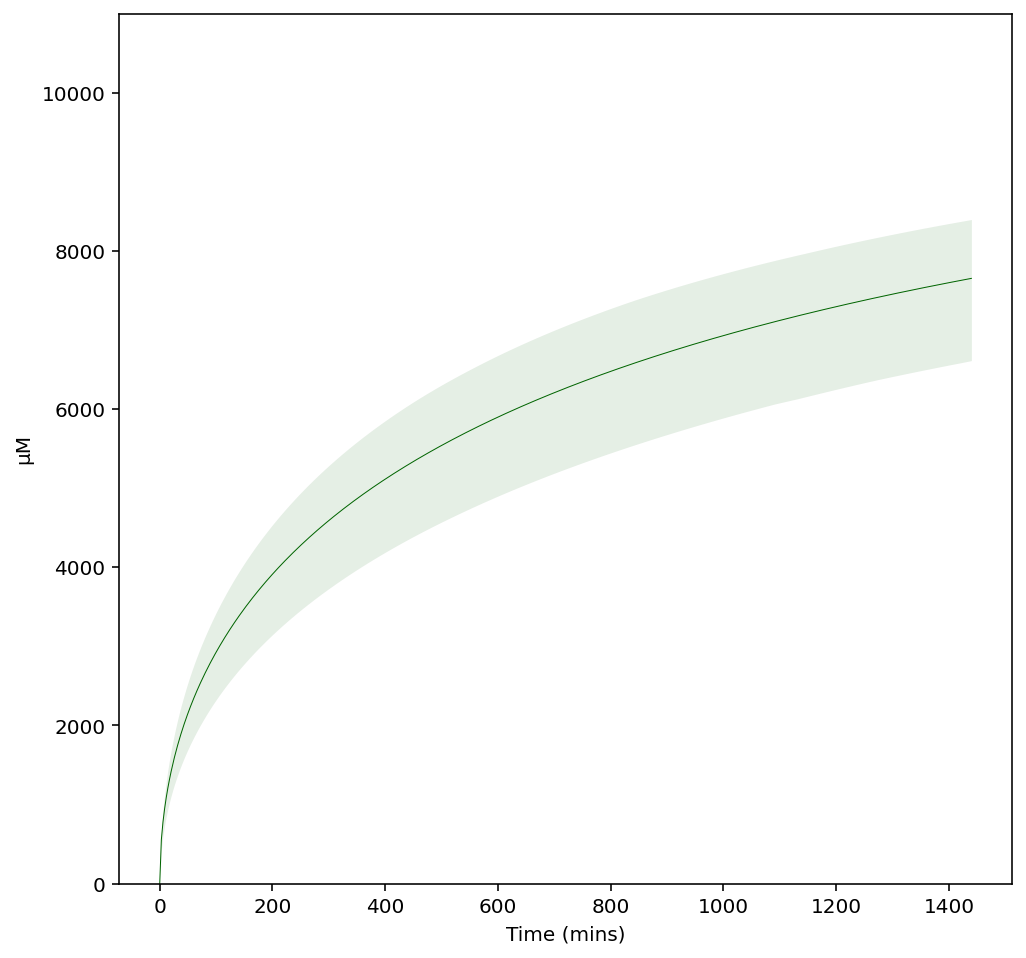

-- NADPH --


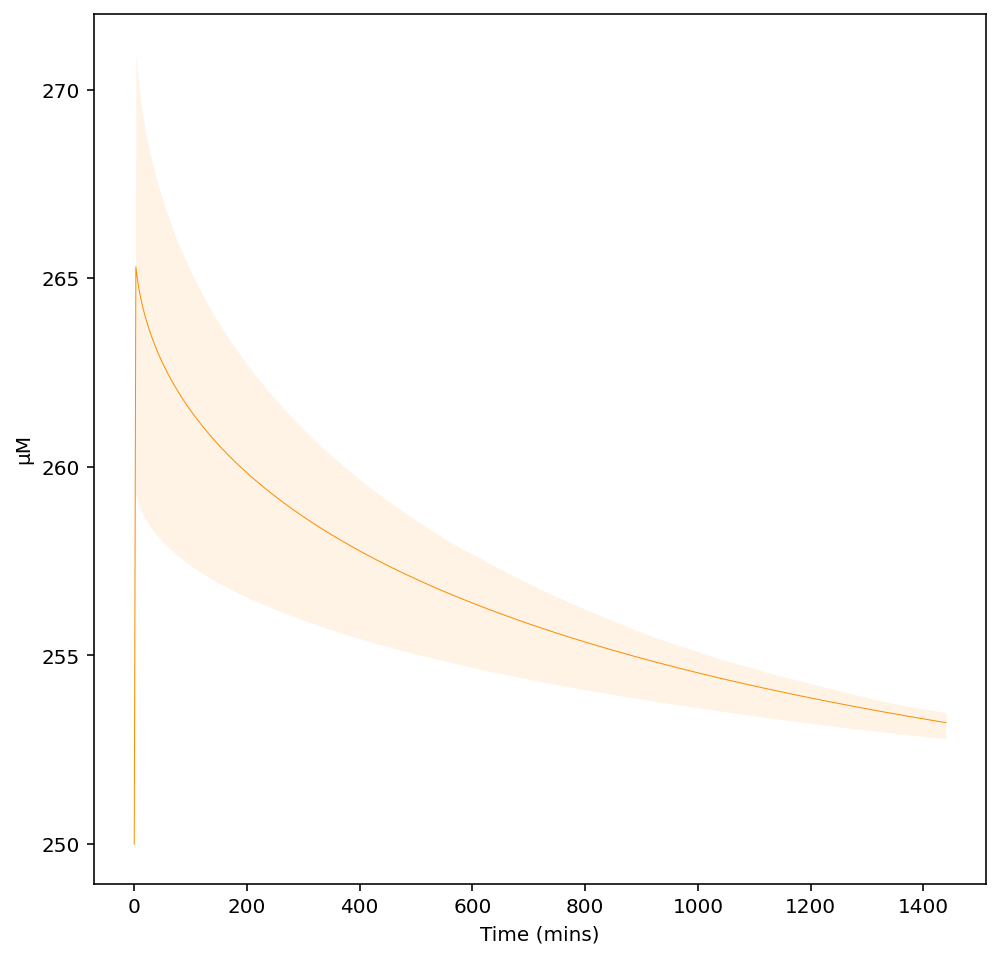

-- NADP --


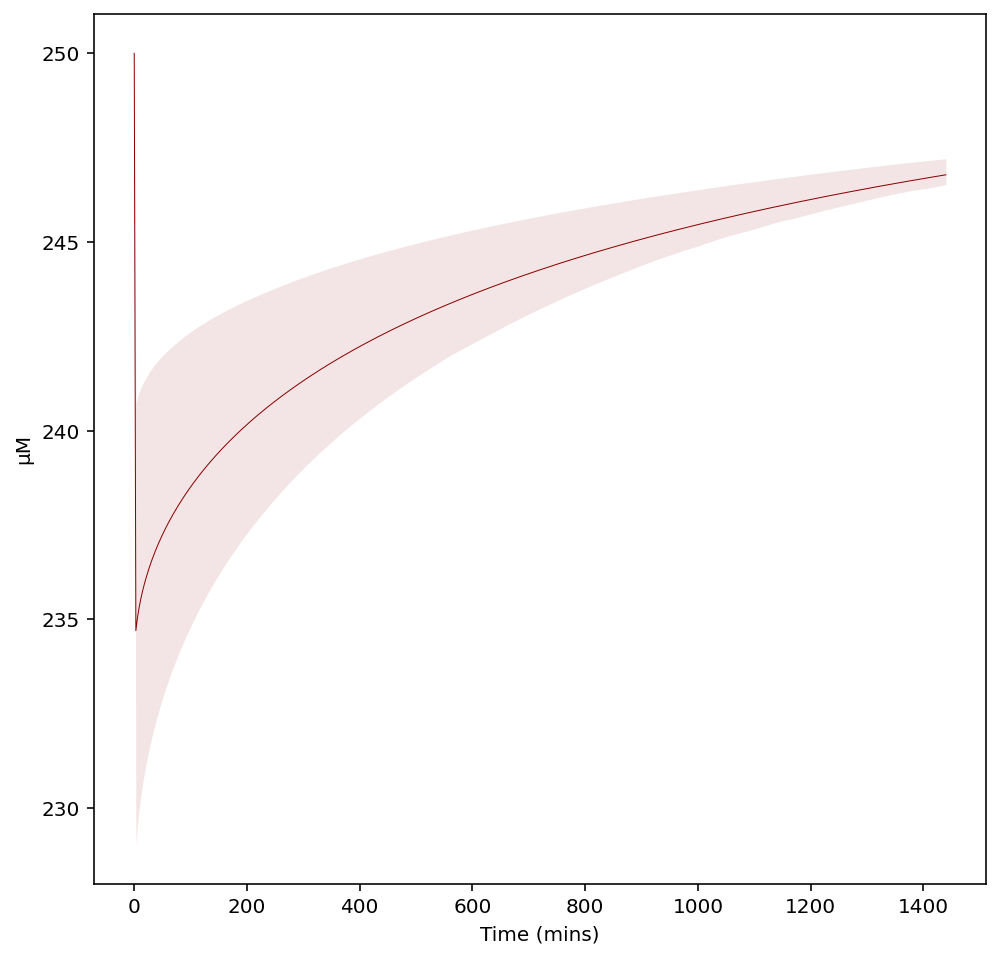

In [227]:
# Plot the confidence intervals
print("-- Alcohol --")
kinetics.plot_ci_intervals(['alcohol'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
plt.ylim(0, 11000)
plt.show()


print("-- Aldehyde --")
kinetics.plot_ci_intervals(['aldehyde'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
plt.ylim(0, 11000)
plt.show()

print("-- Amine --")
kinetics.plot_ci_intervals(['amine'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
plt.ylim(0, 11000)
plt.show()


print("-- NADPH --")
kinetics.plot_ci_intervals(['nadph'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
#plt.ylim(0, 500)
plt.show()


print("-- NADP --")
kinetics.plot_ci_intervals(['nadp'], df95,
                           units=['μM', 'Time (mins)'],
                           alpha=0.1)
#plt.ylim(0, 500)
plt.show()

## Plot amine excess vs conversion

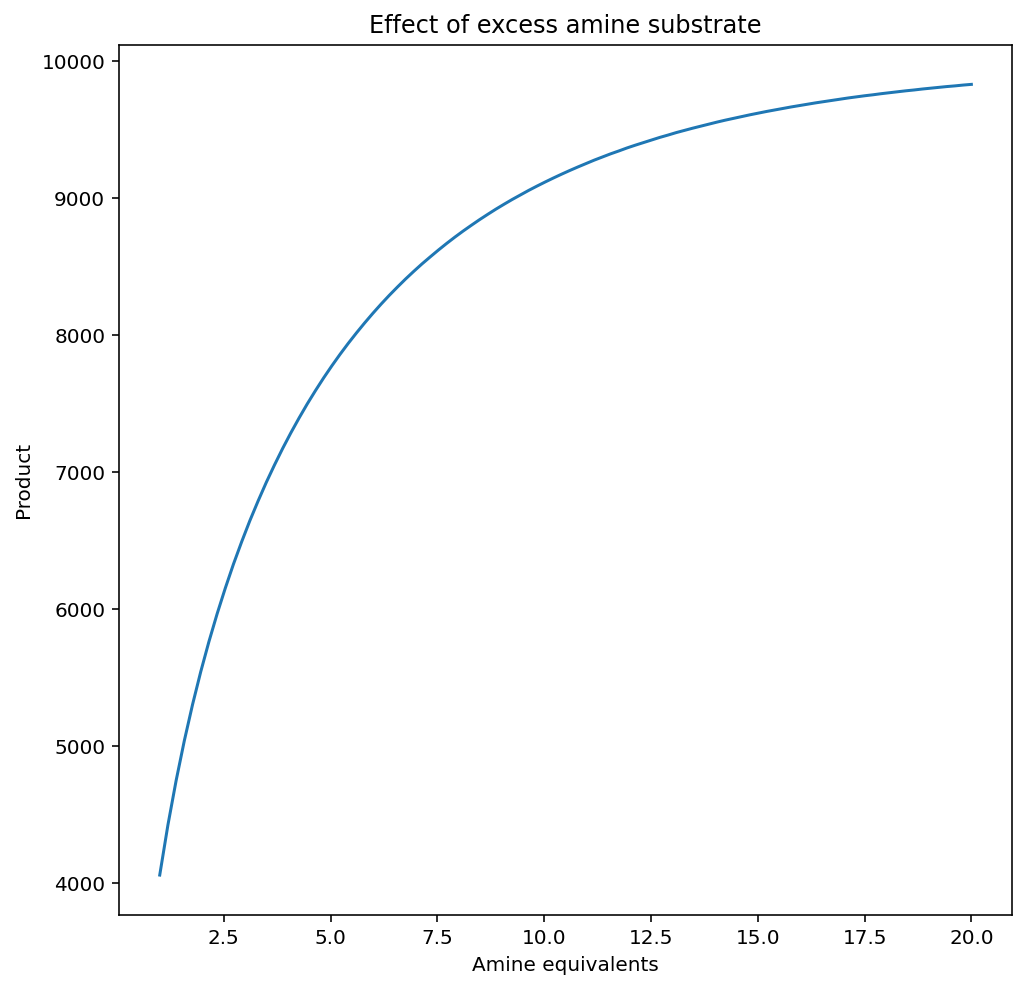

In [228]:
amine_range = np.linspace(1, 20, 100)
results = []
for conc in amine_range:
    model.species['nh2'] = conc*10000
    model.setup_model()
    model.run_model()
    df = model.results_dataframe()
    amine_conc = round(df['amine'].iloc[-1],0)
    results.append(amine_conc)

plt.plot(amine_range, results, '-')
plt.xlabel("Amine equivalents")
plt.ylabel("Product")
plt.title("Effect of excess amine substrate")
plt.show()

## NADPH:NADP+

In [229]:
# Set starting concentrations with no error
# Issue setting concs to 0, so initialise at 1.
model.species = {"ired" : 320,
                 "adh": 285,
                 "nadph": 250,
                 "nadp": 250,
                 "alcohol": 9998,
                 "aldehyde": 1,
                 "amine": 1,
                 "nh2": 50000,  
                 'h2o': 5500000}

# Command to prepare model for running.
model.setup_model()

In [230]:
from bokeh.palettes import Viridis5 as palette
colors = itertools.cycle(palette) 

total_range = np.linspace(100, 5000, 5)
ratio_range = np.linspace(0.1, 10, 10)
results = []

p = figure(title="NADPH:NADP+ vs conversion", x_axis_label='NADPH:NADP ratio', y_axis_label='Product', y_range=(0, 10000))

for total in total_range:
    total = int(total)
    results = []
    for ratio in ratio_range:
        nadp = total_nadph / (ratio+1)
        nadph = total_nadph - nadp

        model.species['nadph'] = nadph
        model.species['nadp'] = nadp
        model.setup_model()
        model.run_model()
        df = model.results_dataframe()
        amine_conc = round(df['amine'].iloc[-1],0)
        results.append(amine_conc)
    p.line(ratio_range, results, legend_label=f"{total} total NADP(H)", color=next(colors), line_width=2)

show(p)


## Effect of pH
Previous calculations have all used the equilibrium constant calculated at pH 7.5.  
What happens when we change pH (and also ionic strength and Mg conc). 

In [231]:
import numpy as np
from equilibrator_api import ComponentContribution, Q_
from equilibrator_assets.generate_compound import create_compound, get_or_create_compound
from rdkit import Chem
from equilibrator_api import Reaction
from equilibrator_cache import Q_
from component_contribution.predict import GibbsEnergyPredictor

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
%config InlineBackend.figure_format ='retina'

from math import log10, floor

from numpyarray_to_latex.jupyter import to_jup

cc = ComponentContribution()
GP = GibbsEnergyPredictor()

cc.p_h = Q_(7.5)
cc.p_mg = Q_(0)
cc.ionic_strength = Q_("0.25M")
T = 298.15
R = 8.31446261815324
cc.temperature = Q_(f"{T}K")

In [232]:
# define smiles
alcohol_smi = "OCC1=CC=CC=C1"
aldehyde_smi = "O=CC1=CC=CC=C1"
amine_substrate_smi = "NC1CC1"  # cyclopropylamine
amine_product_smi = "C(NC1CC1)C1=CC=CC=C1"  # benzyaldehyde + cycloproylamine product
list_smis = [alcohol_smi, aldehyde_smi, amine_substrate_smi, amine_product_smi]

# get compounds for use with equilibrator
compounds = get_or_create_compound(cc.ccache, list_smis, mol_format="smiles")

alcohol = compounds[0]
aldehyde = compounds[1]
amine_substrate = compounds[2]
amine_product = compounds[3]

nadph = cc.search_compound("nadph")
nadp = cc.search_compound("nadp")
h2o = cc.search_compound("h2o")

In [233]:
adh_reaction = Reaction({alcohol: -1, 
                         nadp: -1,
                         aldehyde: +1,
                         nadph: +1,})

ired_reaction = Reaction({aldehyde: -1, 
                          nadph: -1,
                          amine_substrate: -1,
                          amine_product: +1,
                          nadp: +1,
                          h2o: +1})

reactions = [adh_reaction, ired_reaction]

In [234]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def calc_keq(reaction, pH=7.5):
    ''' returns the Keq for a given reaction, with error '''
    
    cc.p_h = Q_(pH)
    dG0_prime = cc.standard_dg_prime(reaction)
    dG0_prime_j_mol = dG0_prime.value.m_as("J/mol")
    dG0_prime_j_mol_error = dG0_prime.error.m_as("J/mol")
    
    dG0_prime_lower = dG0_prime_j_mol - dG0_prime_j_mol_error
    dG0_prime_upper = dG0_prime_j_mol + dG0_prime_j_mol_error
    lower_upper = sorted([dG0_prime_lower, dG0_prime_upper], reverse=True)
    
    keq = round_sig(np.exp(-dG0_prime_j_mol/(R*T)))
    keq_lower = round_sig(np.exp(-lower_upper[0]/(R*T)))
    keq_upper = round_sig(np.exp(-lower_upper[1]/(R*T)))

    #keq_error = np.exp(-dG0_prime_j_mol_error/(R*T))
    #print([keq_lower, keq_upper])
    return keq, [keq_lower, keq_upper]

In [235]:
model.species = {"ired" : 320,
                 "adh": 285,
                 "nadph": 250,
                 "nadp": 250,
                 "alcohol": 9998,
                 "aldehyde": 1,
                 "amine": 1,
                 "nh2": 20000,  
                 'h2o': 5500000}

# Command to prepare model for running.
model.setup_model()

## pH vs vs amine vs conversion

In [238]:
from bokeh.palettes import Viridis6 as palette
colors = itertools.cycle(palette) 

pH_range = np.linspace(4, 12, 25)
amine_range = [50, 10, 5, 2, 1, 0.5]

results = []
p = figure(title="pH & amine vs conversion", x_axis_label='pH', y_axis_label='Product')


for amine in amine_range:
    results = []
    model.species['nh2'] = amine*10000
    model.setup_model()
    
    for pH in pH_range:
        model.parameters['adh_keq'] = calc_keq(adh_reaction, pH=pH)[0]
        model.parameters['ired_keq'] = calc_keq(ired_reaction, pH=pH)[0]
        model.setup_model()
        model.run_model()
        df = model.results_dataframe()
        amine_conc = round(df['amine'].iloc[-1],0)
        results.append(amine_conc)
        
    p.line(pH_range, results, legend_label=f"{amine} amine equivs", color=next(colors), line_width=2)

show(p)


In [239]:
pH_range = np.linspace(11, 5, 7)
amine_range = np.linspace(0.5, 10, 20)
p = figure(title="pH & amine vs conversion", x_axis_label='Amine equivs', y_axis_label='Product')

from bokeh.palettes import Viridis7 as palette
colors = itertools.cycle(palette) 


for pH in pH_range:
    results = []
    for amine in amine_range:
        model.species['nh2'] = amine*10000
        model.parameters['adh_keq'] = calc_keq(adh_reaction, pH=pH)[0]
        model.parameters['ired_keq'] = calc_keq(ired_reaction, pH=pH)[0]
        model.setup_model()
        model.run_model()
        df = model.results_dataframe()
        amine_conc = round(df['amine'].iloc[-1],0)
        results.append(amine_conc)
        
    p.line(amine_range, results, legend_label=f"pH {pH}", color=next(colors), line_width=2)

show(p)